# 🔊🎧 Moodify  
**Moodify is a speech-based music recommendation system that uses AI to detect emotions in a person's voice and recommend music that matches their emotional state, enhancing personalization and mood alignment.**

---

## ⚙️ Method 2 Overview

This system processes an input `.wav` audio file and performs two main tasks:

1. 🎭 **Speech Emotion Recognition**  
   Uses deep learning to analyze vocal features like pitch, tone, MFCCs, and spectral stats to classify emotions such as:
   - 😠 ANG (Angry)
   - 😢 SAD (Sad)
   - 😀 HAP (Happy)
   - 😐 NEU (Neutral)
   - 😨 FEA (Fear)
   - 😒 DIS (Disgust)

2. 🎵 **Music Recommendation via Spotify**  
   Based on the detected emotion, the system queries Spotify to suggest emotionally relevant songs:
   - Happy → Pop  
   - Sad → Classical  
   - Angry → Rock  
   - Neutral → Chill  
   - Fear → Metal  
   - Disgust → Emo

---

## 🌟 Key Features
- 🎚️ End-to-end audio processing with `librosa`
- 🧠 CNN-based emotion classification
- 🔁 5-fold cross-validation for reliable accuracy
- ⚖️ SMOTE to handle class imbalance
- 🎧 Spotify integration for real-time music suggestions
- 📊 Visualizations of training history and confusion matrix

---

## 🔄 Phases

### 🎧 Audio Processing
- Extracts features from audio using `librosa`:
  - MFCCs, Mel spectrograms, chroma, spectral contrast, tonnetz
  - Harmonic/percussive separation and statistical descriptors

### 🧠 Speech Emotion Recognition
- Trains a 1D CNN with regularization and dropout
- Uses stratified 5-fold cross-validation
- Applies SMOTE and class weighting to deal with imbalanced emotion labels

### 🎵 Music Recommendation
- Maps the predicted emotion to a genre
- Uses the `spotipy` library to fetch top 5 Spotify tracks
- Personalized output based on detected mood

---

## 🪜 Steps

🔹 **1. Imports and Setup**  
   - Load required libraries, set configurations for augmentation, SMOTE, and logging.

🔹 **2. Audio Augmentation**  
   - Add noise, pitch shift, and time stretch for training robustness.

🔹 **3. Feature Extraction**  
   - Extract multiple statistical and spectral audio features per file.

🔹 **4. Load and Prepare Data**  
   - Label encoding, feature scaling, saving the scaler and label encoder.

🔹 **5. Handle Class Imbalance with SMOTE**  
   - Balances emotion categories before training.

🔹 **6. Build CNN Model**  
   - 1D CNN with Conv, MaxPooling, BatchNorm, Dropout, and Dense layers.

🔹 **7. Cross-Validation Training**  
   - Performs 5-fold CV, saves best model, tracks metrics.

🔹 **8. Evaluation and Visualization**  
   - Classification report, confusion matrix, and training plots.

🔹 **9. Predict Emotion for New Audio**  
   - Load best model, preprocess single file, and predict emotion.

🔹 **10. Recommend Music using Spotify API**  
   - Fetches top 5 tracks based on the detected emotion and mapped genre.

🔹 **11. Test on Sample Audio Files**  
   - Runs prediction + recommendation on real `.wav` files .

---


In [1]:
# ---------------------- Step 1 : Imports and Setup ----------------------
import os
import numpy as np
import librosa
import glob
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import seaborn as sns
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization, Conv1D,
                                     MaxPooling1D, Flatten)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import math
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
#disable warnings
warnings.filterwarnings('ignore')

In [3]:
#Install required packages
!pip install -r requirements.txt

In [4]:
# ---------------------- Config ----------------------
USE_DATA_AUGMENTATION = True
USE_LOG_MEL = True
USE_SMOTE = True
USE_CLASS_WEIGHTS = True
TEST_SIZE = 0.15
RANDOM_STATE = 42

In [5]:

# ---------------------- Step 2 : Audio Augmentation ----------------------
def augment_audio(audio, sr):
    if not USE_DATA_AUGMENTATION:
        return [audio]
    aug_audios = [audio]
    noise = 0.005 * np.random.randn(len(audio))
    aug_audios.append(audio + noise)
    aug_audios.append(librosa.effects.pitch_shift(audio, sr=sr, n_steps=2))
    aug_audios.append(librosa.effects.time_stretch(audio, rate=0.8))
    return aug_audios

In [6]:

# ----------------------Step 3 : Feature Extraction ----------------------
def extract_features(audio_files, sr=22050, n_mfcc=40, hop_length=512):
    features_list = []
    labels_list = []
    for file in audio_files:
        label = os.path.basename(file).split("_")[2]
        audio, _ = librosa.load(file, sr=sr)
        audio, _ = librosa.effects.trim(audio, top_db=30)

        for aug_audio in augment_audio(audio, sr):
            features = []
            if USE_LOG_MEL:
                mel_spec = librosa.feature.melspectrogram(y=aug_audio, sr=sr, n_mels=128)
                log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
                features = np.mean(log_mel_spec, axis=1).tolist() + np.std(log_mel_spec, axis=1).tolist()
            else:
                mfcc = librosa.feature.mfcc(y=aug_audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
                features = [np.mean(mfcc[i]) for i in range(n_mfcc)] + [np.std(mfcc[i]) for i in range(n_mfcc)]

            features_list.append(features)
            labels_list.append(label)

    return np.array(features_list), np.array(labels_list)

In [7]:
# ---------------------- Cosine Annealing Scheduler ----------------------
def cosine_annealing(epoch, lr_max=0.003, lr_min=1e-6, T_max=50):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / T_max))

# ---------------------- Step 4 : Load Data ----------------------
CREMA_PATH = "AudioWAV/"
audio_files = glob.glob(os.path.join(CREMA_PATH, "*.wav"))
X, y = extract_features(audio_files)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save both after fitting
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

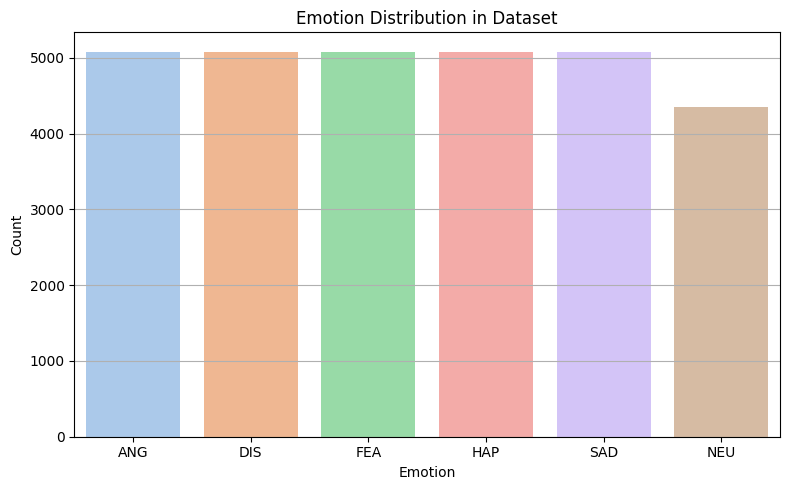

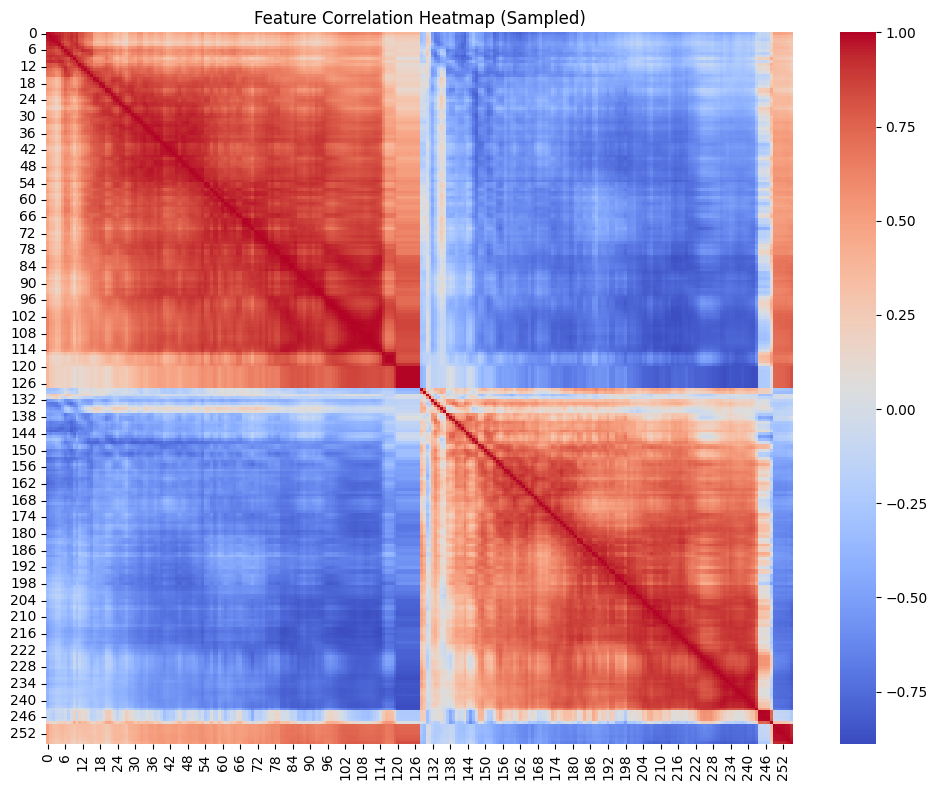

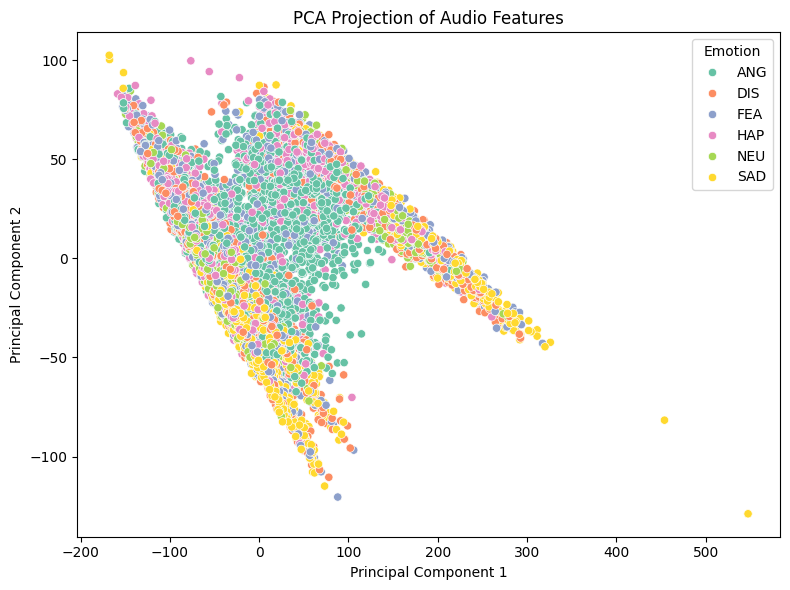

In [11]:
# ---------------------- Exploratory data analysis ----------------------

# 1. Emotion label counts
emotion_counts = pd.Series(y).value_counts()
emotion_labels = emotion_counts.index 


plt.figure(figsize=(8, 5))
sns.barplot(x=emotion_labels, y=emotion_counts.values, palette="pastel")
plt.title("Emotion Distribution in Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 2. Feature correlation heatmap

# Use first 100 samples for fast plotting
sample_features_df = pd.DataFrame(X[:100])
sample_corr = sample_features_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(sample_corr, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap (Sampled)")
plt.tight_layout()
plt.show()

# 3. PCA visualization of feature space 
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=label_encoder.inverse_transform(y_encoded),  # ← Now using encoded labels
    palette="Set2"
)
plt.title("PCA Projection of Audio Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

In [12]:

# Dataset preparation and split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y_encoded, test_size=TEST_SIZE, stratify=y_encoded, random_state=RANDOM_STATE)

print(f"Training set: {len(X_train_full)} files\nTest set: {len(X_test)} files")

#---------Step 5,6,and 7

# ---------------------- Model ----------------------
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(0.003), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ---------------------- 5-Fold Stratified CV ----------------------
y_cat_test = to_categorical(y_test)
X_train_full = X_train_full.reshape(X_train_full.shape[0], X_train_full.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
best_val_acc = 0
fold_accuracies = []
histories = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full, y_train_full)):
    print(f"\nFold {fold+1}")
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    if USE_SMOTE:
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        sm = SMOTE(random_state=RANDOM_STATE)
        X_train_flat, y_train = sm.fit_resample(X_train_flat, y_train)
        X_train = X_train_flat.reshape(X_train_flat.shape[0], X_train.shape[1], 1)

    y_cat_train = to_categorical(y_train)
    y_cat_val = to_categorical(y_val)

    class_weights = None
    if USE_CLASS_WEIGHTS:
        class_totals = Counter(y_train)
        total = sum(class_totals.values())
        class_weights = {cls: total / (len(class_totals) * count) for cls, count in class_totals.items()}

    model = create_model((X_train.shape[1], 1), y_cat_train.shape[1])
    model_path = f"model_fold_{fold+1}.h5"

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max'),
        LearningRateScheduler(lambda epoch: cosine_annealing(epoch, T_max=100))
    ]

    history = model.fit(X_train, y_cat_train,
                        validation_data=(X_val, y_cat_val),
                        epochs=100,
                        batch_size=32,
                        callbacks=callbacks,
                        class_weight=class_weights,
                        verbose=0)

    val_loss, val_acc = model.evaluate(X_val, y_cat_val, verbose=0)
    print(f"Validation Accuracy for Fold {fold+1}: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save("best_emotion_model-method2.h5")

    fold_accuracies.append(val_acc)
    histories.append(history)

Training set: 25302 files
Test set: 4466 files

Fold 1


Validation Accuracy for Fold 1: 0.6426

Fold 2


Validation Accuracy for Fold 2: 0.6345

Fold 3


Validation Accuracy for Fold 3: 0.6302

Fold 4


Validation Accuracy for Fold 4: 0.6352

Fold 5


Validation Accuracy for Fold 5: 0.6451



Fold-wise Accuracy:
     Fold Accuracy
0  Fold 1   0.6426
1  Fold 2   0.6345
2  Fold 3   0.6302
3  Fold 4   0.6352
4  Fold 5   0.6451


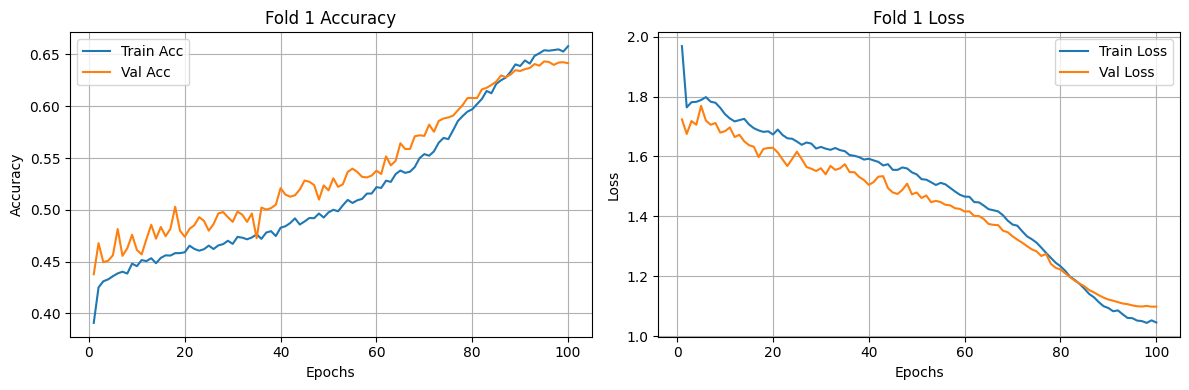

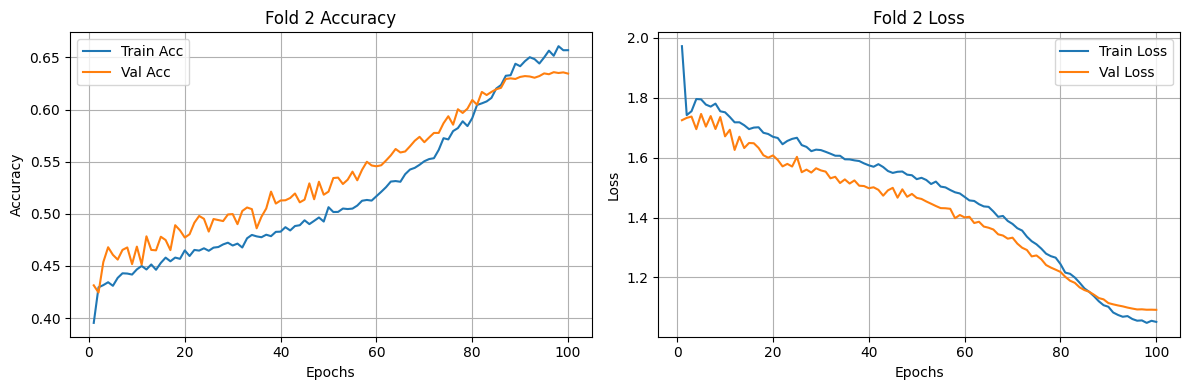

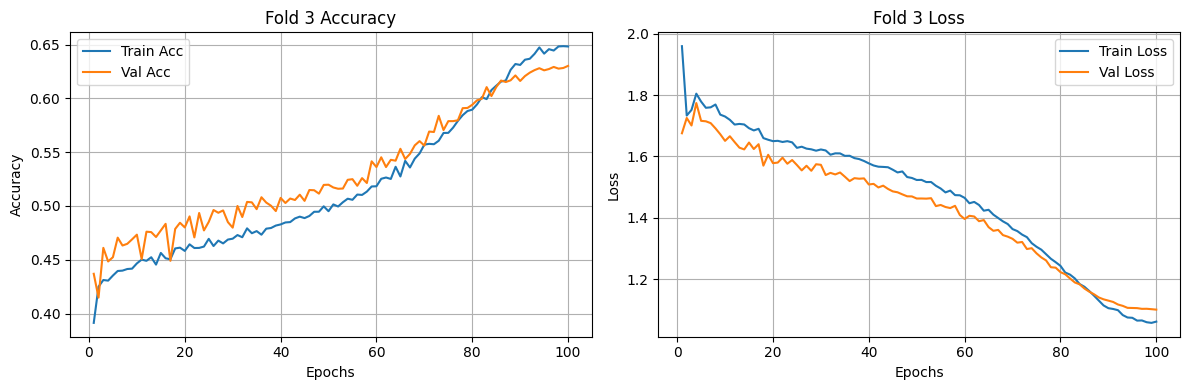

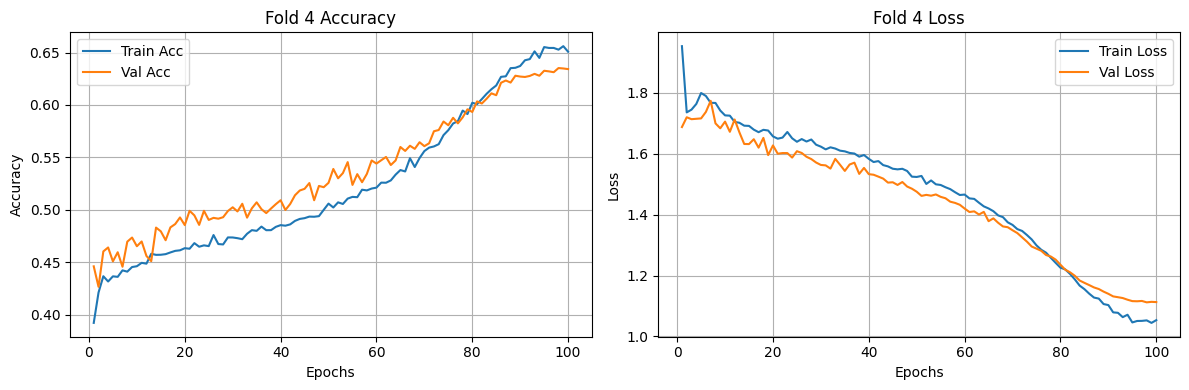

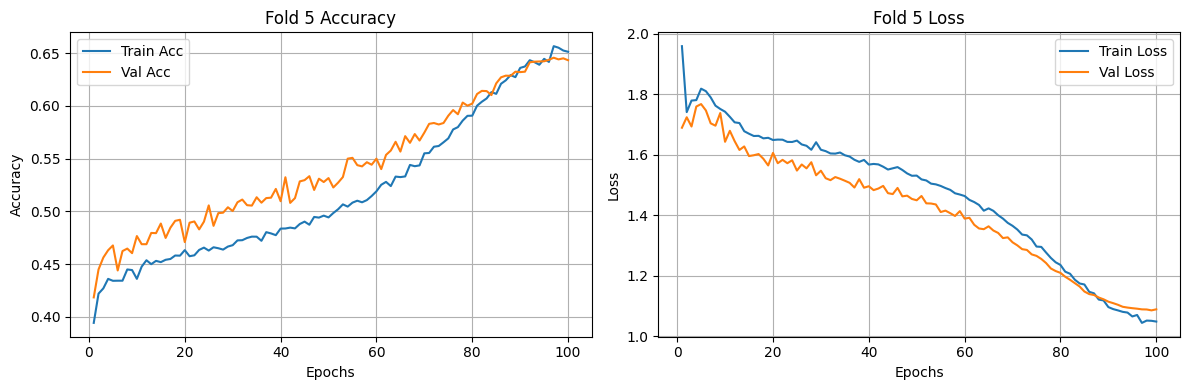


Evaluating on holdout test set...


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Classification Report:
              precision    recall  f1-score   support

         ANG       0.77      0.82      0.79       763
         DIS       0.57      0.54      0.55       762
         FEA       0.71      0.48      0.57       763
         HAP       0.63      0.61      0.62       763
         NEU       0.56      0.74      0.64       652
         SAD       0.62      0.67      0.64       763

    accuracy                           0.64      4466
   macro avg       0.64      0.64      0.64      4466
weighted avg       0.65      0.64      0.64      4466



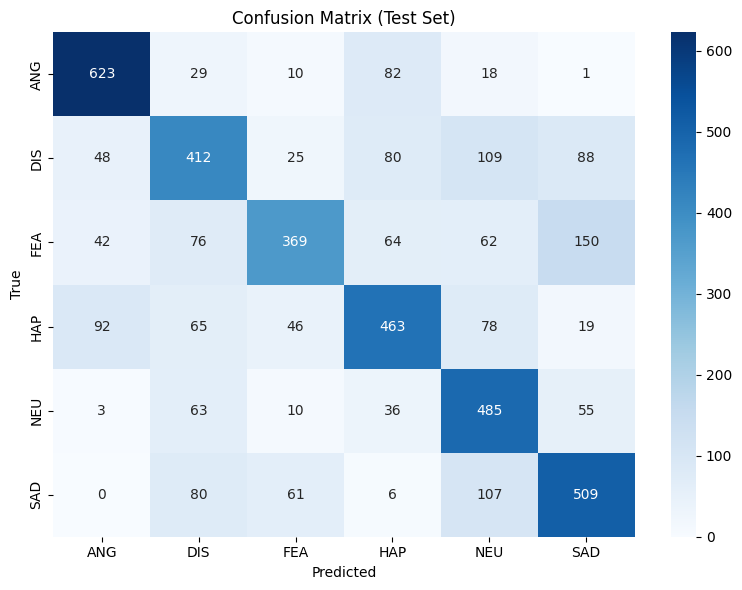

In [13]:
#Step 8
# ---------------------- Fold Accuracy ----------------------
fold_results = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(5)],
    "Accuracy": [f"{acc:.4f}" for acc in fold_accuracies]
})
print("\nFold-wise Accuracy:")
print(fold_results)

# ---------------------- Accuracy and Loss Plot ----------------------
def plot_folds(histories):
    for i, history in enumerate(histories):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Train Acc')
        plt.plot(epochs, val_acc, label='Val Acc')
        plt.title(f'Fold {i+1} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Train Loss')
        plt.plot(epochs, val_loss, label='Val Loss')
        plt.title(f'Fold {i+1} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

plot_folds(histories)

# ---------------------- Final Evaluation on Holdout ----------------------
print("\nEvaluating on holdout test set...")
best_model = load_model("best_emotion_model-method2.h5")
y_pred = best_model.predict(X_test_reshaped)
y_pred_class = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [14]:
# ---------------------- Step 10 :Music Recommendation ----------------------
def recommend_music(emotion):
    load_dotenv()
    client_id = os.getenv("SPOTIPY_CLIENT_ID")
    client_secret = os.getenv("SPOTIPY_CLIENT_SECRET")
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

    mood_map = {
        'HAP': 'pop', 
        'SAD': 'classical', 
        'ANG': 'rock',
        'NEU': 'chill', 
        'FEA': 'metal', 
        'DIS': 'emo'
    }
    genre = mood_map.get(emotion, 'pop')
    results = sp.search(q=f"genre:{genre}", limit=5)
    print(f"\nTop tracks for {emotion} mood:")
    for track in results['tracks']['items']:
        print(f"{track['name']} by {track['artists'][0]['name']}")

# ---------------------- Predict Audio  Emotion----------------------
def predict_and_recommend(file_path, model, label_encoder, scaler):
    feats, _ = extract_features([file_path])  
    
    feats_scaled = scaler.transform(feats)  
    feats_mean = np.mean(feats_scaled, axis=0)  
    
    feats_reshaped = feats_mean.reshape(1, -1, 1) 
    preds = model.predict(feats_reshaped)
    
    pred_label = np.argmax(preds)
    emotion = label_encoder.inverse_transform([pred_label])[0]

    print("Prediction Probabilities:")
    for cls, prob in zip(label_encoder.classes_, preds[0]):
        print(f"{cls}: {prob:.2%}")
    recommend_music(emotion)
    return emotion


# ---------------------- Step 11: Prediction on Sample Audio ----------------------
def test_audio_prediction(audio_path):
    actual = os.path.basename(audio_path).split("_")[2]
    predicted = predict_and_recommend(audio_path, best_model, label_encoder, scaler)
    print(f"\nFile: {os.path.basename(audio_path)}")
    print(f"Actual Emotion:    {actual}")
    print(f"Predicted Emotion: {predicted}")
    print("-------------------------------------------------------------")

In [15]:
# Test audio predictions
test_audio_prediction("AudioWAV/1002_IEO_ANG_HI.wav")
test_audio_prediction("AudioWAV/1059_WSI_HAP_XX.wav")
test_audio_prediction("AudioWAV/1042_IEO_FEA_HI.wav")
test_audio_prediction("AudioWAV/1013_IEO_DIS_HI.wav")
test_audio_prediction("AudioWAV/1060_TAI_SAD_XX.wav")
test_audio_prediction("AudioWAV/1088_IWW_NEU_XX.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction Probabilities:
ANG: 62.93%
DIS: 13.45%
FEA: 0.52%
HAP: 21.51%
NEU: 1.37%
SAD: 0.21%

Top tracks for ANG mood:
505 by Arctic Monkeys
Sweater Weather by The Neighbourhood
Dreams - 2004 Remaster by Fleetwood Mac
Mr. Brightside by The Killers
Iris by The Goo Goo Dolls

File: 1002_IEO_ANG_HI.wav
Actual Emotion:    ANG
Predicted Emotion: ANG
-------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction Probabilities:
ANG: 20.77%
DIS: 21.79%
FEA: 8.08%
HAP: 44.19%
NEU: 0.75%
SAD: 4.42%

Top tracks for HAP mood:
BIRDS OF A FEATHER by Billie Eilish
Sailor Song by Gigi Perez
Die With A Smile by Lady Gaga
Good Luck, Babe! by Chappell Roan
No One Noticed by The Marías

File: 1059_WSI_HAP_XX.wav
Actual Emotion:    HAP
Predicted Emotion: HAP
-------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Prediction Probabilities:
ANG: 17.58%
DIS: 43.14%
FEA: 29.14%
HA